In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from deepant import (
    deepant_settings,
    DeepAnt,
    run_inference,
    plot_losses,
    detect_anomalies,
)
from evaluation import create_ground_truth, fix_dates, convert_dates
from config_paths import AUX_PATHS

In [3]:
OUT_DIMENSION = 1
TRAIN = False
CHECKPOINT_VERSION = "v6"
SETTINGS = dict(
    batch_size=5096,
    nw=8,
    epochs=30,
    fast_dev_run=False,
    overfit_batches=0,
    name="DeepAnt",
)
train_set = np.load(f"../data/prep_data/train_set.npz", allow_pickle=True)
test_set = np.load(f"../data/prep_data/test_set.npz", allow_pickle=True)

model = DeepAnt(OUT_DIMENSION)
trainer, anomaly_detector, dm = deepant_settings(
    model, train_set, test_set, SETTINGS, train=TRAIN
)


trained_model = anomaly_detector.load_from_checkpoint(
    f"../samsara/checkpoints/DeepAnt-best-checkpoint-{CHECKPOINT_VERSION}.ckpt",
    model=model,
)
trained_model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


ForecastBasedAD(
  (model): DeepAnt(
    (convblock1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=valid)
      (1): ReLU(inplace=True)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (convblock2): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=valid)
      (1): ReLU(inplace=True)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (denseblock): Sequential(
      (0): Linear(in_features=32, out_features=40, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.25, inplace=False)
    )
    (out): Linear(in_features=40, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

In [4]:
ground_truth = create_ground_truth(
    AUX_PATHS, cols_to_keep=["ID", "IDpix", "Finicio", "Ffinal"]
)
ground_truth = ground_truth.pipe(fix_dates).pipe(convert_dates)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

The Choosen Threshold corresponds to: 0.23280157148838043


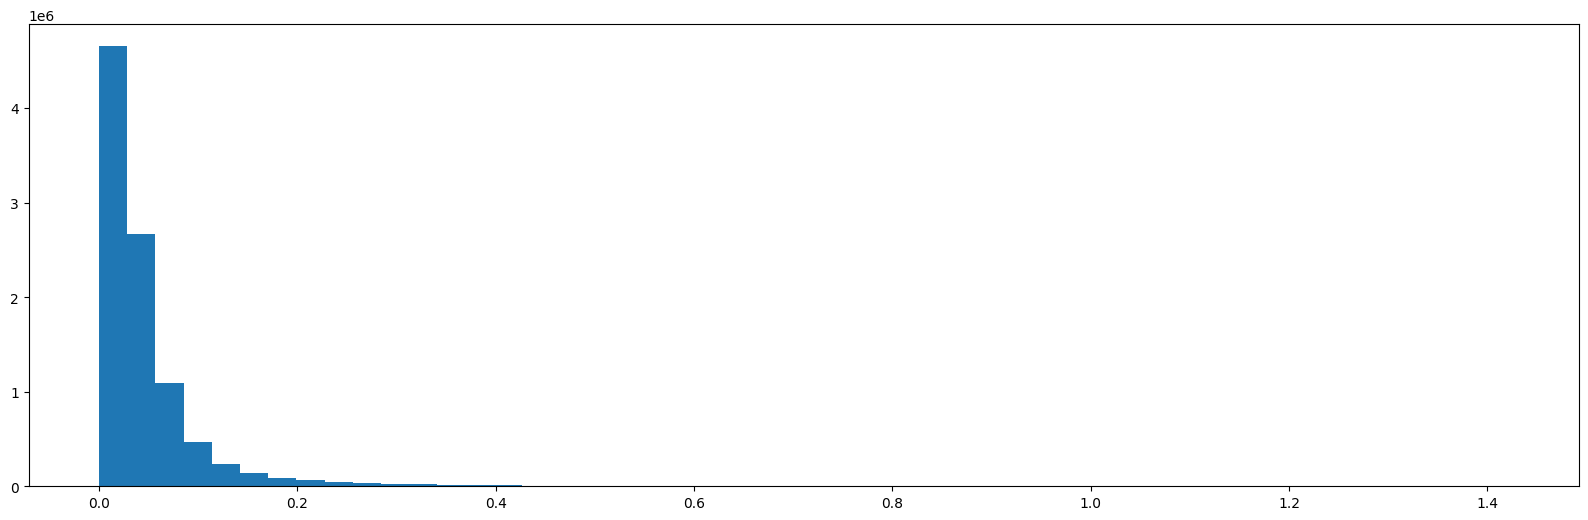

In [5]:
preds, val_losses = run_inference(trainer, anomaly_detector, dm)
assert test_set["sequences"].shape[0] == val_losses.shape[0]
threshold = plot_losses(val_losses)
print(f"The Choosen Threshold corresponds to: {threshold}")
anomalies = (
    detect_anomalies(test_set, val_losses, threshold=threshold)
    .merge(ground_truth, how="left", on=["NAME", "IDpix", "ID"])
    .assign(
        is_right=lambda x: (x.Finicio <= x.target_dates) & (x.target_dates <= x.Ffinal),
        P_id=lambda x: x.NAME + "-" + x.ID.astype(str),
    )
)
anomalies.to_parquet(f"../data/predictions/{SETTINGS['name']}_preds.parquet")

In [6]:
anomalies

,target_indices,target_dates,NAME,IDpix,ID,Finicio,Ffinal,is_right,P_id
0,ESTABLE-221-6,2016-03-13,ESTABLE,221,6,2004-12-17,2022-05-01,True,ESTABLE-6
1,ESTABLE-222-6,2016-03-13,ESTABLE,222,6,2004-12-17,2022-05-01,True,ESTABLE-6
2,ESTABLE-223-6,2016-03-13,ESTABLE,223,6,2004-12-17,2022-05-01,True,ESTABLE-6
3,ESTABLE-224-6,2016-03-13,ESTABLE,224,6,2004-12-17,2022-05-01,True,ESTABLE-6
4,ESTABLE-225-6,2016-03-13,ESTABLE,225,6,2004-12-17,2022-05-01,True,ESTABLE-6
...,...,...,...,...,...,...,...,...,...
202570,VARIOS-632-337,2022-11-06,VARIOS,632,337,2017-08-13,2018-02-20,False,VARIOS-337
202571,VARIOS-633-337,2022-11-06,VARIOS,633,337,2017-08-13,2018-02-20,False,VARIOS-337
202572,VARIOS-571-337,2022-11-13,VARIOS,571,337,2017-08-13,2018-02-20,False,VARIOS-337
202573,VARIOS-573-337,2022-11-13,VARIOS,573,337,2017-08-13,2018-02-20,False,VARIOS-337
